# Comparison of stat-tests for AB Testing using Monte-Carlo simulation

## Table of Contents
* [Introduction](#params)
* [Comparison of tests](#ztest)
    * [Z-Test](#ztest)
    * [T-Test](#ttest)
    * [Mann-Whitneyu U-test](#utest)
    * [Bootstrap](#bootstrap)
    * [Manual check](#manual)
* [Time complexity](#time)
* [Conclusions](#conc)

# Introduction <a class="anchor" id="params"></a>

In this work, I will focus only on the last part of AB testing - evaluation results. I will compare two samples from the same(AA test) or different(AB test) populations. I will generate samples from distributions, assuming that they are the results of AB testing. Each sample is a list containing 0s and 1s where 1 is some target action or proxy metric (of course it can be something more difficult such as a list of CTR's of users or other metrics or observations from which we can calculate metrics; I chose 0s and 1s for simplicity)

Then I will use Monte-Carlo to simulate different tests and get p-values distribution

H0 hypothesis: there is no difference between samples
H1 hypothesis: no H0 (there is difference)

I will simulate AA and AB tests for following methods:
 - Z-Test
 - T-Test
 - U-Test
 - Bootstrap
 - Manual check with Monte-Carlo
 
(Explanation I wrote inside first test is valid for all others)

In [311]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [341]:
metric = 0.15  # baseline metric
uplift = 0.05  # mde (minimum detectable effect)
test_power = 0.90
alpha = 0.05  

Calculate minimal sample size for tests using these parameters:

In [344]:
effect_size = sms.proportion_effectsize(metric, metric+uplift)

sample_size = sms.NormalIndPower().solve_power(
    effect_size, 
    power=test_power, 
    alpha=alpha, 
    ratio=1
)

sample_size = int(np.ceil(sample_size))

print(f'For tests you need minimul {sample_size} people')

For tests you need minimul 1208 people


Both sample are from binomial distribution with different probability parameter:

In [314]:
A_sample = lambda: np.random.binomial(n=1, p=metric, size=sample_size)
B_sample = lambda: np.random.binomial(n=1, p=metric+uplift, size=sample_size)

Check if distributions are really different:

In [315]:
print(np.mean([np.mean(A_sample()) for _ in range(10000)]))
print(np.mean([np.mean(B_sample()) for _ in range(10000)]))

0.15010306291390726
0.20012599337748344


Prepare basic needed functions:

In [345]:
def monte_carlo(test, aa=False, **kwargs):
    p_values = []
    # simulate 10000 times, each time generate new samples, run test and save results
    for _ in range(10000):
        A = A_sample()
        B = A_sample() if aa else B_sample()
        _, p_value = test(A, B, **kwargs)
        p_values.append(p_value)

    p_values = np.array(sorted(p_values))
    
    return p_values

In [346]:
def plot_p_values(p_values, aa=False):
    
    if not aa:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        sns.histplot(p_values, ax=ax[0])
        sns.histplot(p_values[p_values < 0.1], bins=10, ax=ax[1])
        ax[1].axvline(alpha, linestyle='dashed', color='red', label='alpha')
        ax[1].legend()
        fig.suptitle('Distribution of p-values', fontsize=20);
        
    else:
        _, ax = plt.subplots(figsize=(10, 5))
        sns.histplot(p_values, ax=ax)
        ax.set_title('Distribution of p-values', fontsize=15);
    
    plt.show()

# Z-test <a class="anchor" id="ztest"></a>

Run one time the test to check if it works:

(I shown two types of ztest, it can be seen that in this case they act almost the same, so I will use `ztest`)

In [318]:
A = A_sample()
B = B_sample()

print(ztest(A, B, value=0))

print(proportions_ztest(
    (np.sum(A), np.sum(B)),
    (sample_size, sample_size)
))

(-2.270202525721109, 0.023195297838978005)
(-2.2687222262845017, 0.02328522310578634)


### AA test

For AA test I take two samples from the same distribution:

In [319]:
p_values = monte_carlo(ztest, aa=True, value=0)

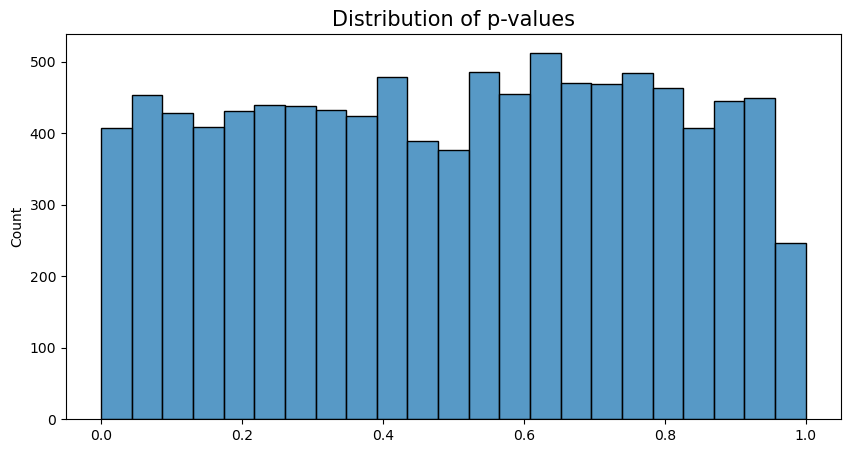

In [320]:
plot_p_values(p_values, aa=True)

To clarify, when the null hypothesis is true and other assumptions are met, the p-value is uniformly distributed. This is because alpha, the probability of a type I error, is defined as the maximum acceptable level of significance for rejecting a true null hypothesis. To reject the null hypothesis, the observed p-value must be less than alpha. Therefore, for any value of alpha, the only way to ensure that the probability of rejecting a true null hypothesis is alpha is for the p-value to be uniformly distributed. The appropriate distribution (normal, t, etc.) is used to convert the test statistic to a uniform p-value. When the null hypothesis is false, the distribution of p-values should be skewed towards 0 or 1 to indicate a significant difference between the observed and expected values.

### AB test

In [321]:
p_values = monte_carlo(ztest, value=0)

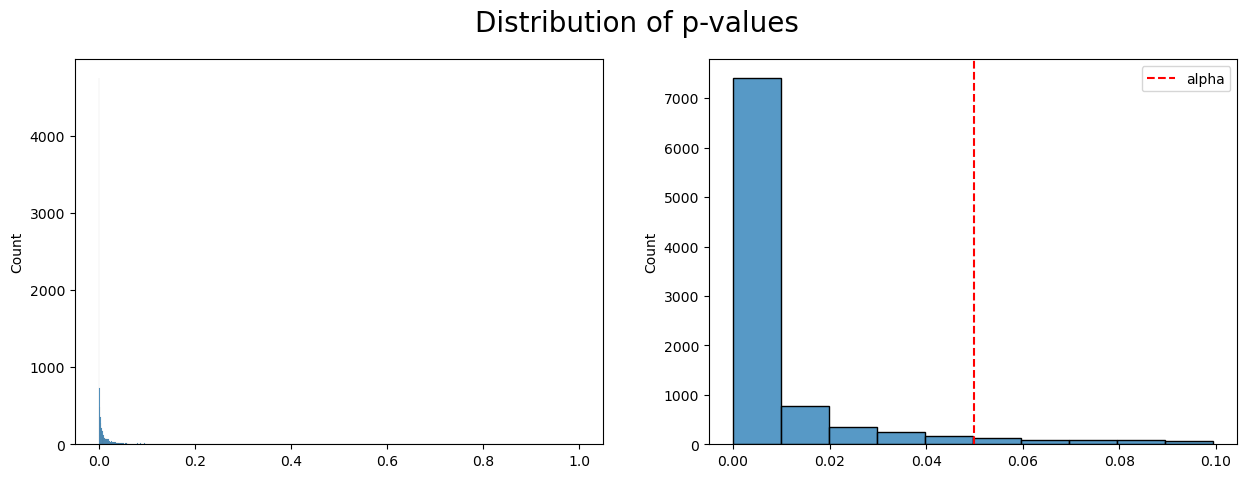

In [322]:
plot_p_values(p_values)

In [323]:
real_test_power = np.mean(p_values < alpha)
print(f'Real test power = {round(real_test_power * 100, 3)}%')
rel_diff = np.abs(test_power - real_test_power) / test_power * 100
print(f'Relative difference between expected test power and actual = {round(rel_diff, 2)}%')

Real test power = 89.7%
Relative difference between expected test power and actual = 0.33%


About 90% of p-values are smaller that alpha. It is exactly what our test power means, probability to detect minimum detectable effect (mde)(`uplift` in this code). If the differenct between our setted power and calculated actual power would be to hight, we could assume that the something is designed incorrectly.

# T-test <a class="anchor" id="ttest"></a>

In [324]:
A = A_sample()
B = B_sample()

print(ttest_ind(A, B))

Ttest_indResult(statistic=-5.458301778757452, pvalue=5.2979574871209576e-08)


### AA test

In [325]:
p_values = monte_carlo(ttest_ind, aa=True)

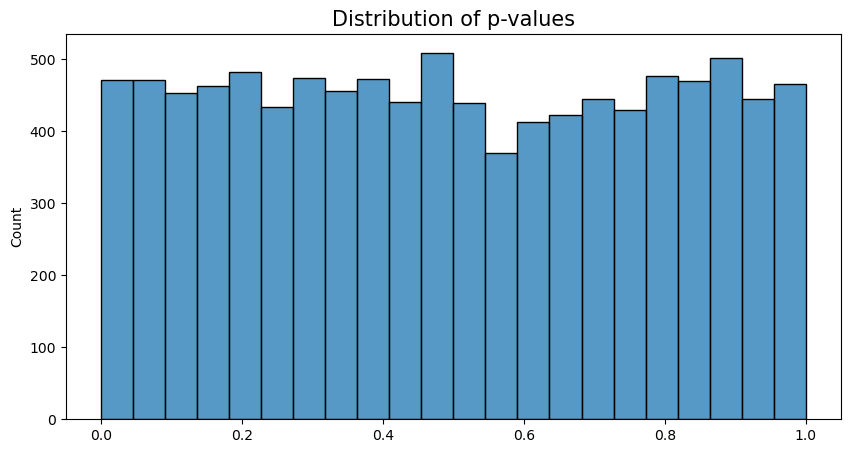

In [326]:
plot_p_values(p_values, aa=True)

### AB test

In [327]:
p_values = monte_carlo(ttest_ind)

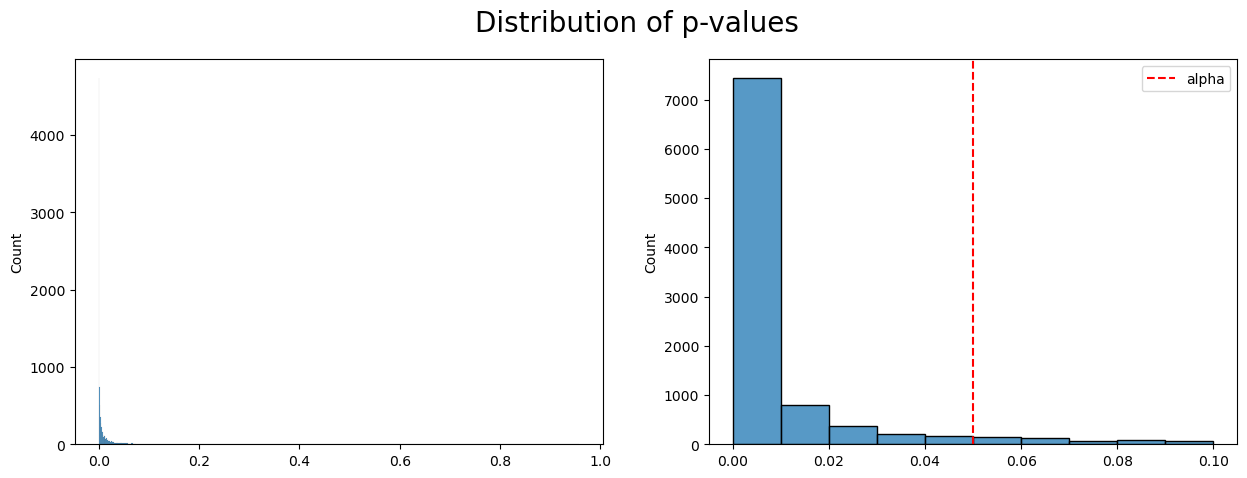

In [328]:
plot_p_values(p_values)

In [329]:
real_test_power = np.mean(p_values < alpha)
print(f'Real test power = {round(real_test_power * 100, 3)}%')
rel_diff = np.abs(test_power - real_test_power) / test_power * 100
print(f'Relative difference between expected test power and actual = {round(rel_diff, 2)}%')

Real test power = 90.24%
Relative difference between expected test power and actual = 0.27%


# Mann-Whitneyu U-test <a class="anchor" id="utest"></a>

In [330]:
A = A_sample()
B = B_sample()

print(mannwhitneyu(A, B))

MannwhitneyuResult(statistic=677084.0, pvalue=3.4977377424572456e-06)


### AA test

In [331]:
p_values = monte_carlo(mannwhitneyu, aa=True)

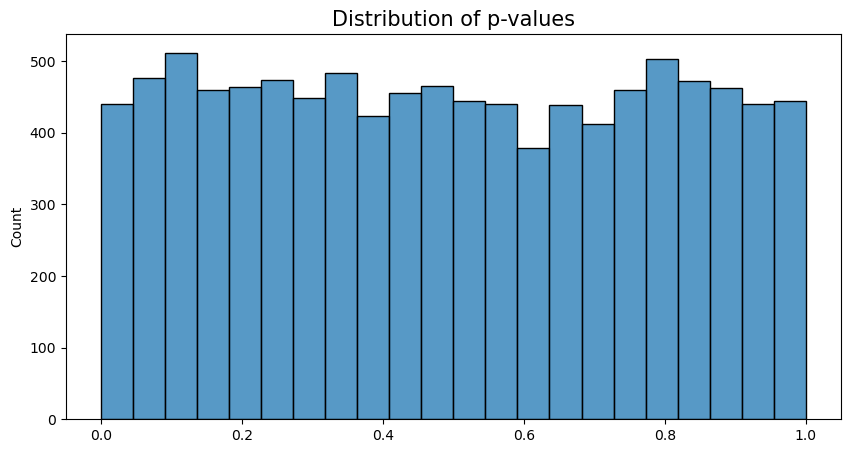

In [332]:
plot_p_values(p_values, aa=True)

### AB test

In [333]:
p_values = monte_carlo(mannwhitneyu)

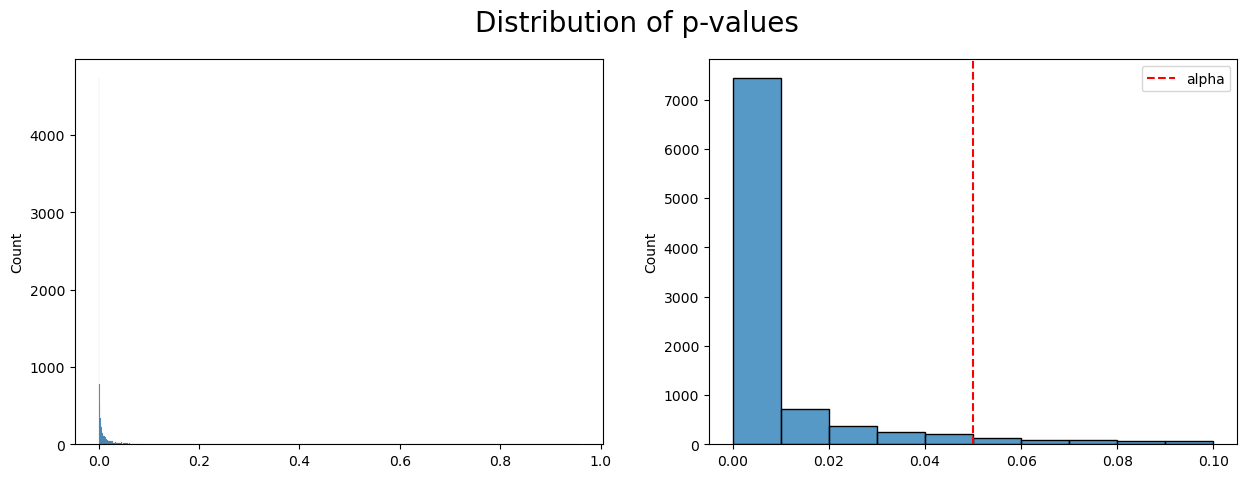

In [334]:
plot_p_values(p_values)

In [335]:
real_test_power = np.mean(p_values < alpha)
print(f'Real test power = {round(real_test_power * 100, 3)}%')
rel_diff = np.abs(test_power - real_test_power) / test_power * 100
print(f'Relative difference between expected test power and actual = {round(rel_diff, 2)}%')

Real test power = 89.99%
Relative difference between expected test power and actual = 0.01%


# Bootstrap <a class="anchor" id="bootstrap"></a>

In [189]:
def bootstrap(A, B, boot_it):
    diffs = []
    # do bootstrap many times
    for _ in range(boot_it):
        # each time create new sample of the same size from real one, using sampling with replacement
        a_boot = np.random.choice(A, len(A))
        b_boot = np.random.choice(B, len(B))
        # and calcutate statistics 
        diff = np.mean(a_boot) - np.mean(b_boot)
        diffs.append(diff)
    
    diffs = np.array(diffs)
    # You can calculate n% confidence interval for diffs and check if 0 is inside, 
    # but I will calculate p-value using this method  
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(diffs), 
        scale = np.std(diffs)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(diffs), 
        scale = np.std(diffs)
    )
    p_value = min(p_1, p_2) * 2
    
    return _, p_value

In [190]:
A = A_sample()
B = B_sample()

print(bootstrap(A, B, 1000)[-1])

2.6354368202602563e-06


### AA test

In [196]:
p_values = monte_carlo(bootstrap, aa=True, boot_it=1000)

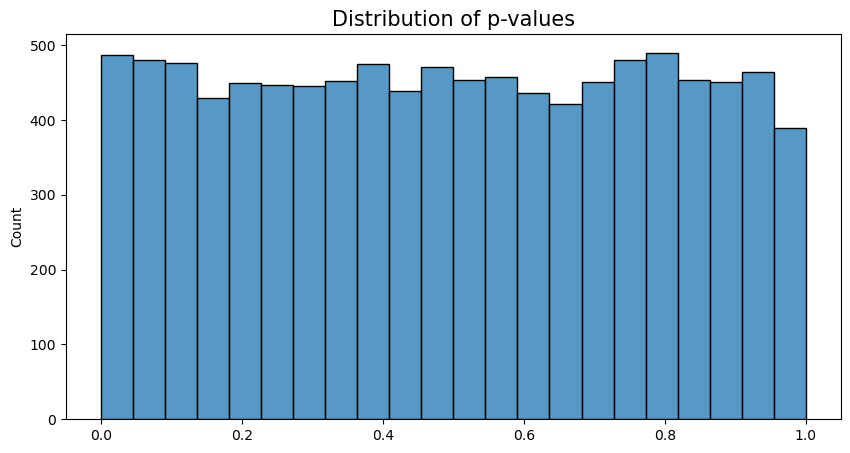

In [197]:
plot_p_values(p_values, aa=True)

### AB test

In [199]:
p_values = monte_carlo(bootstrap, boot_it=1000)

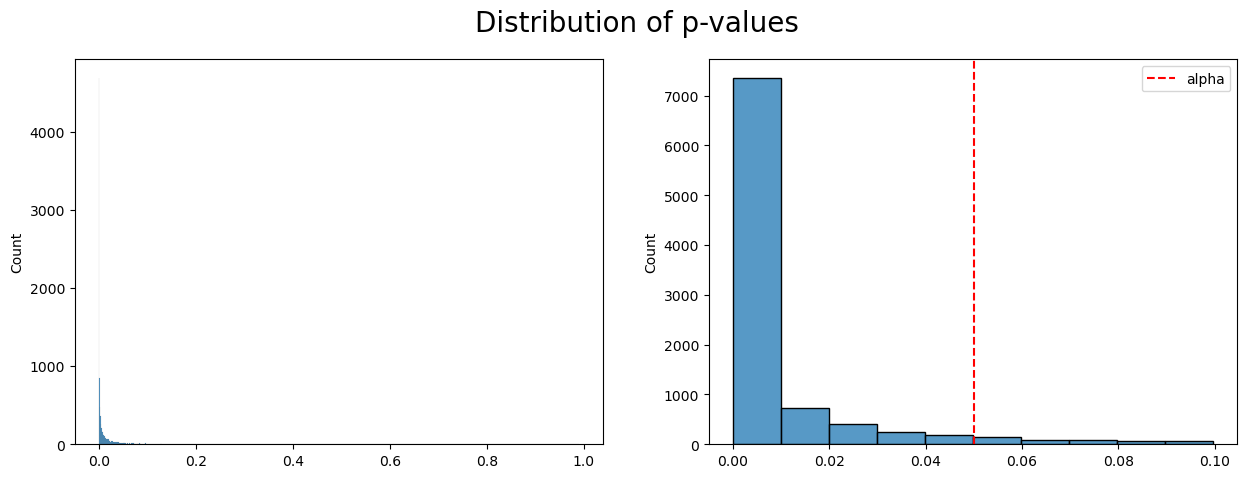

In [200]:
plot_p_values(p_values)

In [337]:
real_test_power = np.mean(p_values < alpha)
print(f'Real test power = {round(real_test_power * 100, 3)}%')
rel_diff = np.abs(test_power - real_test_power) / test_power * 100
print(f'Relative difference between expected test power and actual = {round(rel_diff, 2)}%')

Real test power = 89.44%
Relative difference between expected test power and actual = 0.62%


# Manual Monte Carlo <a class="anchor" id="manual"></a>

In [278]:
def manual_check(A, B): 
    diffs = []
    prob = np.mean(np.concatenate((A, B)))
    # we assume that two samples are from the same distribution, and in this case we can 
    # easily compute probability parameter for binomial distribution, and sample two new samples
    # which are truly from the same distribution, then compare statistics
    for _ in range(1000):
        A_new = np.random.binomial(n=1, p=prob, size=len(A))
        B_new = np.random.binomial(n=1, p=prob, size=len(B))
        diff = np.abs(np.mean(A_new) - np.mean(B_new))
        diffs.append(diff)

    diffs = np.array(diffs)

    real_diff = np.abs(np.mean(A) - np.mean(B))
    p_value = np.mean(real_diff <= diffs)

    return _, p_value

In [285]:
A = A_sample()
B = B_sample()

print(manual_check(A, B)[-1])

0.007


### AA test

In [286]:
p_values = monte_carlo(manual_check, aa=True)

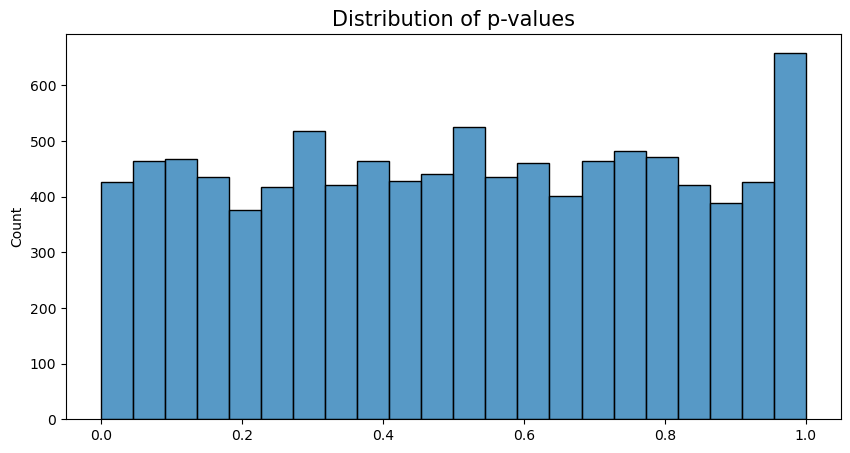

In [287]:
plot_p_values(p_values, aa=True)

### AB test

In [289]:
p_values = monte_carlo(manual_check)

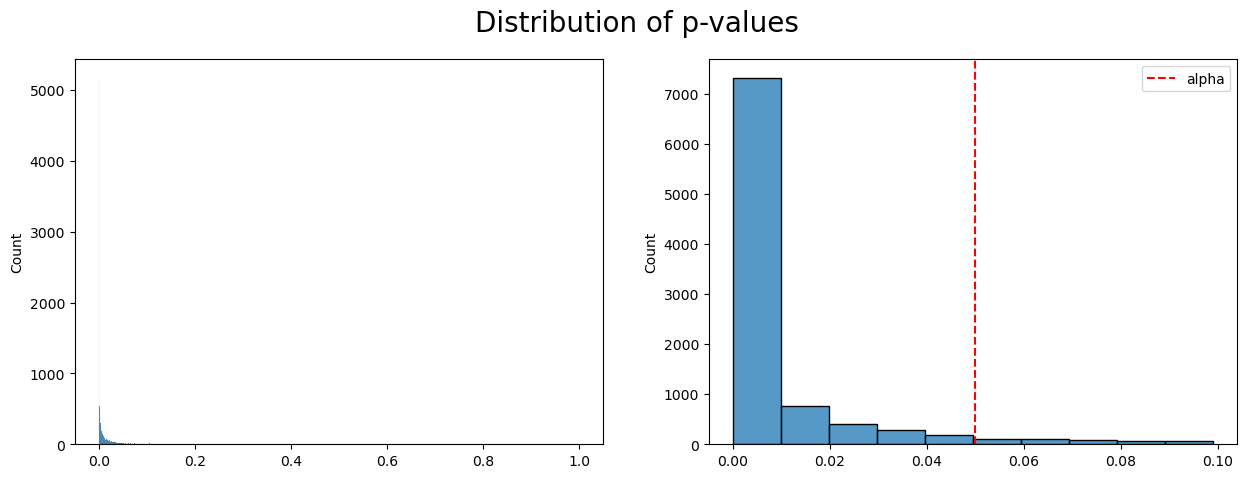

In [290]:
plot_p_values(p_values)

In [339]:
real_test_power = np.mean(p_values < alpha)
print(f'Real test power = {round(real_test_power * 100, 3)}%')
rel_diff = np.abs(test_power - real_test_power) / test_power * 100
print(f'Relative difference between expected test power and actual = {round(rel_diff, 2)}%')

Real test power = 89.63%
Relative difference between expected test power and actual = 0.41%


# Time complexity <a class="anchor" id="time"></a>

In [292]:
A = A_sample()
B = B_sample()

In [300]:
%%timeit
ztest(A, B, value=0)

116 µs ± 3.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [301]:
%%timeit
ttest_ind(A, B)

159 µs ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [297]:
%%timeit
mannwhitneyu(A, B)

800 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [298]:
%%timeit
bootstrap(A, B, 1000)[-1]

75.5 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [299]:
%%timeit
manual_check(A, B)[-1]

47.9 ms ± 521 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Conclusions <a class="anchor" id="conc"></a>

There was not any significant difference between tests in terms of p-values with default parameters. The difference can be observed if mde is smaller (some tests are less sensitive) when the sample size does not match with other parameters, when there are more outliers (non-parametric u-test would be better than parametric t-test), and which is the most common when the distribution is different. Generally bootstrap is the most robust method, concerning the fact that you can calculate other statistics such as median inside it (and the main bootstrap problem, computational complexity can be mitigated using [Poisson bootstrap](https://github.com/Giminosk/poisson-bootstrap/blob/main/poisson-bootstrap.ipynb)).

There were no big difference between planned and actual power, thus we correctly conducted the simulation of the tests.

As for time complexity, it is clear that the fastest tests are z-test and t-test (z-test mainly not used in practice). U-test is much slower, which is logical considering its structure. And bootstrap is definetely the slowest one (even using 1000 of bootstraps which is generally not as much)